In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PrepareData import prepare_dataset
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

## Prepare dataset

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset()

/home/simon/Dissertation/Abalone/PrepareData.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_test[['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']])
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3383, 10) (3383,)
(376, 10) (376,)
(418, 10) (418,)


In [4]:
def plot_predictions(pred, y):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 30, 0.1), np.arange(0, 30, 0.1))

In [5]:
def sum_squared_error(pred, y):
    return np.sum((y - pred)**2)

## Encrypted Linear model

In [6]:
model_lin_weights = np.load('model_lin_weights.npy')

In [7]:
X_test_enc = EA(X_test.values, True)

In [8]:
w = EA(model_lin_weights[0])
b = EA(model_lin_weights[1].reshape(1, -1))

In [9]:
pred = X_test_enc.dot(w) + b
pred.shape

(418, 1)

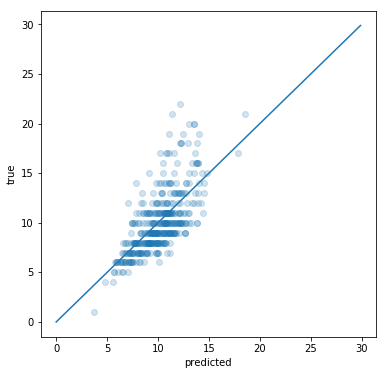

In [10]:
plot_predictions(pred.values().flatten(), y_test)

In [11]:
sse_enc = sum_squared_error(pred.values().flatten(), y_test)
print('SSE encrypted: {}'.format(sse_enc))

SSE encrypted: 2069.4778883855115


In [12]:
pred_clear = np.dot(X_test, model_lin_weights[0]) + model_lin_weights[1]
sse_clear = sum_squared_error(pred_clear.flatten(), y_test)
print('SSE clear: {}'.format(sse_clear))

SSE clear: 2069.4778883855115


## Sigmoid

In [6]:
sig_weights = np.load('model_sig_weights.npy')

In [9]:
w1, b1, w2, b2 = sig_weights

In [12]:
X_test_enc = EA(X_test.values, True)
w1_enc = EA(w1)
b1_enc = EA(b1.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [13]:
layer1_enc = X_test_enc.dot(w1_enc) + b1_enc
layer1_sig = layer1_enc.activate_sigmoid()
pred_enc = layer1_sig.dot(w2_enc) + b2_enc

In [16]:
sum_squared_error(pred_enc.values().reshape(-1,), y_test)

23693.378243713712

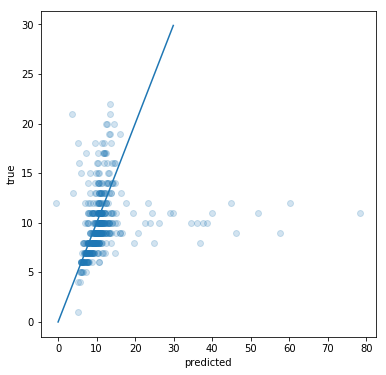

In [17]:
plot_predictions(pred_enc.values().flatten(), y_test)

In [19]:
layer1 = X_test.values.dot(w1) + b1
layer_sig = sigmoid(layer1)
pred = layer_sig.dot(w2) + b2

In [21]:
sum_squared_error(pred.flatten(), y_test)

1917.2039954341187

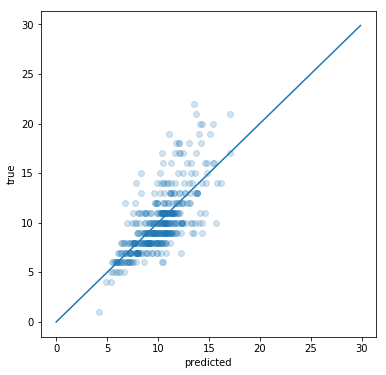

In [22]:
plot_predictions(pred.flatten(), y_test)

## Linear - Batch Normalization

In [23]:
def normalize_weights(w, var, scale):
    return w * scale / np.sqrt(var + 0.001)

In [24]:
def normalize_bias(b, mean, var, shift, scale):
    return (b - mean) * (scale / np.sqrt(var + 0.001)) + shift

In [25]:
norm_weights = np.load('model_norm_weights.npy')

In [26]:
w1, b1, scale, shift, mean, std, w2, b2 = norm_weights

In [27]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale).reshape(1, -1)

In [31]:
w_norm_en = EA(w_norm)
b_norm_en = EA(b_norm)
w2_en = EA(w2)
b2_en = EA(b2.reshape(-1, 1))

In [32]:
layer1_enc = X_test_enc.dot(w_norm_en) + b_norm_en
pred_norm_enc = layer1_enc.dot(w2_en) + b2_en
pred_decrypted = pred_norm_enc.values()

In [35]:
layer1_enc.values().std(axis=0)

array([0.14825635, 1.11574607, 1.51086335])

In [36]:
sum_squared_error(pred_decrypted.reshape(-1,), y_test)

2606.992461284285

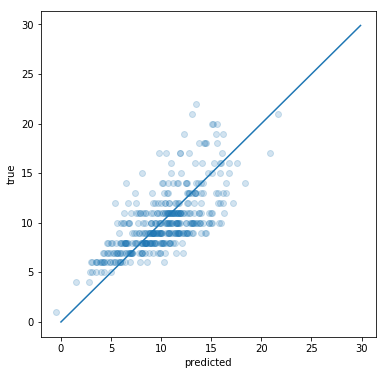

In [37]:
plot_predictions(pred_decrypted.reshape(-1,), y_test)

In [59]:
layer1 = X_test.values.dot(w_norm) + b_norm
pred_norm = layer1.dot(w2) + b2

In [60]:
sum_squared_error(pred_norm.reshape(-1,), y_test)

2606.9924612842833

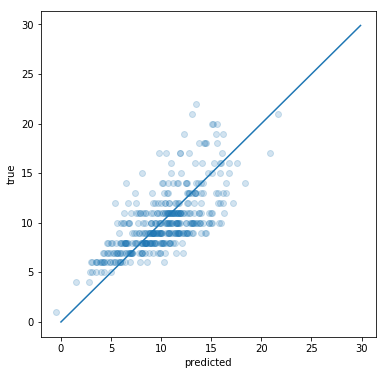

In [62]:
plot_predictions(pred_norm, y_test)

## Sigmoid model - BN with no shift or scale

In [63]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [84]:
%autoreload 2

In [137]:
sig_weights = np.load('model_sig_bn_weights.npy')

In [138]:
w1, b1, mean, std, w2, b2 = sig_weights

In [139]:
# no shifting or scaling
w_norm = normalize_weights(w1, std**2, 1)
b_norm = normalize_bias(b1, mean, std**2, 0, 1)

In [86]:
X_test_enc = EA(X_test.values, True)

In [140]:
w_norm_enc = EA(w_norm)
b_norm_enc = EA(b_norm.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [141]:
layer1 = X_test_enc.dot(w_norm_enc) + b_norm_enc

In [142]:
layer1.values()

array([[ 1.15081271,  0.51932503, -1.98567323],
       [-0.42652872,  0.80191643,  3.32305742],
       [ 1.92636587,  3.00659281, -6.11912786],
       ...,
       [-2.02416656, -1.64056985, -1.94769268],
       [-2.28149246, -1.83673002, -2.86964373],
       [-0.24735508, -0.66533749,  3.75992133]])

In [143]:
layer1_sig = layer1.activate_sigmoid()

In [149]:
layer1_sig.values()

array([[0.75595614, 0.62691378, 0.16666616],
       [0.39498409, 0.68973732, 0.56639581],
       [0.83268773, 0.68552218, 3.74284899],
       ...,
       [0.16671232, 0.18183331, 0.16698106],
       [0.17699652, 0.16988747, 0.27482489],
       [0.43847647, 0.33980064, 0.33278169]])

In [145]:
pred_sig = layer1_sig.dot(w2_enc) + b2_enc

In [146]:
sse_sig_enc = sum_squared_error(pred_sig.values().flatten(), y_test)
print('SSE sigmoid enc: {}'.format(sse_sig_enc))

SSE sigmoid enc: 255939.91026293565


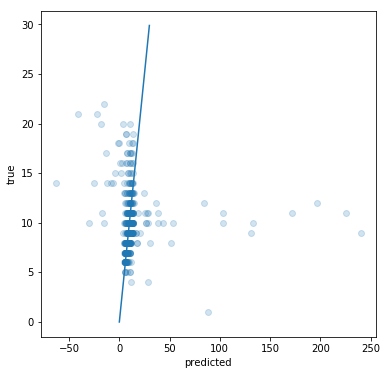

In [147]:
plot_predictions(pred_sig.values().reshape(-1,), y_test)

In [150]:
layer1_clear = X_test.values.dot(w1)
layer1_clear = (layer1_clear - mean) / std
layer1_clear

array([[ 0.97885532,  0.71690024, -4.97907251],
       [-0.60518522,  1.00005511,  1.1244139 ],
       [ 1.75770218,  3.20912691, -9.7313358 ],
       ...,
       [-2.20960832, -1.44730078, -4.93540649],
       [-2.46802708, -1.64385203, -5.99538047],
       [-0.4252506 , -0.47012412,  1.62667948]])

In [151]:
layer1_sig_clear = sigmoid(layer1_clear)
pred_sig_clear = layer1_sig_clear.dot(w2) + b2

In [152]:
sse_sig_clear = sum_squared_error(pred_sig_clear.flatten(), y_test)
print('SSE sigmoid clear: {}'.format(sse_sig_clear))

SSE sigmoid clear: 3155.9908199760866


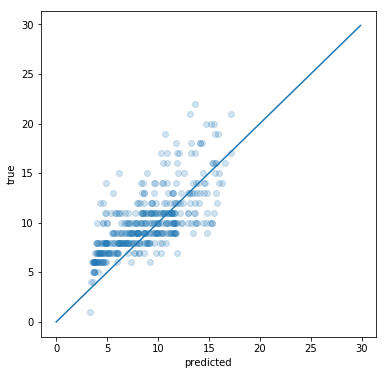

In [153]:
plot_predictions(pred_sig_clear.flatten(), y_test)

## Relu model - 1 Layer

In [279]:
def relu(z):
    return np.maximum(z, 0)

In [280]:
relu_weights = np.load('weights_relu.npy')

In [281]:
w1, b1, scale, shift, mean, std, w2, b2 = relu_weights

In [282]:
w_norm = normalize_weights(w1, std**2, scale)
b_norm = normalize_bias(b1, mean, std**2, shift, scale).reshape(1, -1)

In [283]:
layer1 = X_test_enc.dot(EA(w_norm)) + EA(b_norm.reshape(1, -1))
layer1.activate_squared()
pred_relu = layer1.dot(EA(w2)) + EA(b2.reshape(1, -1))

In [284]:
layer1_clear = X_test.values.dot(w_norm) + b_norm
layer1_relu_clear = relu(layer1_clear)
pred_relu_clear = layer1_relu_clear.dot(w2) + b2

In [285]:
sse_relu_enc = sum_squared_error(pred_relu.values().flatten(), y_test)
print('SSE relu enc: {}'.format(sse_relu_enc))

SSE relu enc: 5136334.508335641


In [286]:
sse_relu_clear = sum_squared_error(pred_relu_clear.flatten(), y_test)
print('SSE relu clear: {}'.format(sse_relu_clear))

SSE relu clear: 3885.6009372439958


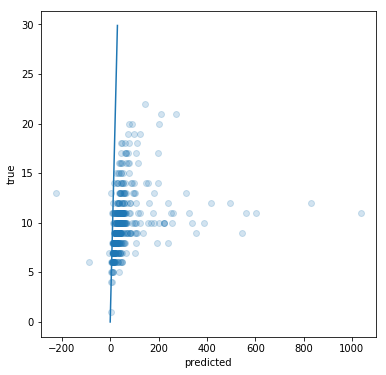

In [287]:
plot_predictions(pred_relu.values().flatten(), y_test)

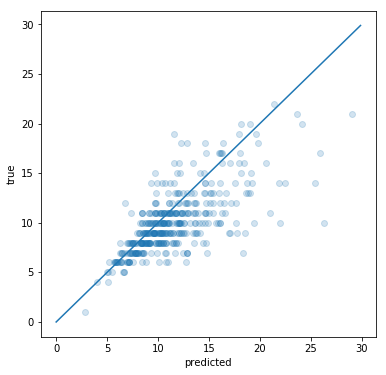

In [288]:
plot_predictions(pred_relu_clear.flatten(), y_test)